# Doodle Recognition Model

This notebook builds a deep learning model to recognize doodles from the QuickDraw dataset.

## Dataset Overview
- Images organized by category in `doodles/doodle/` directory
- CSV file with metadata: countrycode, drawing strokes, key_id, recognized flag, word (category), image_path
- Multiple categories (e.g., airplane, traffic light, cat, etc.)


In [49]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Fix for TensorFlow Metal plugin issue on macOSs
# Disable Metal plugin directory before importing TensorFlow to avoid loading errors
import sys
if sys.platform == 'darwin':  # macOS
    try:
        import site
        venv_path = os.environ.get('VIRTUAL_ENV', '')
        if venv_path:
            # Find Python version directory dynamically
            import glob
            python_dirs = glob.glob(os.path.join(venv_path, 'lib', 'python3.*'))
            if python_dirs:
                python_dir = python_dirs[0]  # Use first match
                plugin_path = os.path.join(python_dir, 'site-packages', 'tensorflow-plugins')
                if os.path.exists(plugin_path):
                    backup_path = plugin_path + '.disabled'
                    if not os.path.exists(backup_path):
                        try:
                            os.rename(plugin_path, backup_path)
                            print(f"Disabled Metal plugin to avoid loading errors: {plugin_path}")
                        except Exception as e:
                            print(f"Note: Could not disable Metal plugin: {e}")
    except Exception as e:
        # If workaround fails, continue anyway - might work without it
        pass

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
# Safely check for GPU/Metal availability
try:
    physical_devices = tf.config.list_physical_devices()
    print(f"Available devices: {physical_devices}")
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(f"GPU Available: {gpu_devices}")
except Exception as e:
    print(f"Note: Could not check device availability: {e}")


TensorFlow version: 2.20.0
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPU Available: []


In [50]:
import tensorflow as tf
def setup_gpu(enable_mixed_precision: bool = True):
    """Setup GPU acceleration with NVIDIA/Apple GPU optimizations.

    Args:
        enable_mixed_precision: Whether to enable global mixed precision policy.
            Keep True for training speed-ups. Set False for evaluation on Apple MPS
            to avoid f16 vs f32 incompatibilities.
    """
    print("Setting up GPU acceleration...")

    # Check for GPU availability
    gpus = tf.config.list_physical_devices('GPU')
    
    if gpus:
        print(f"✓ Found {len(gpus)} GPU(s)")
        for gpu in gpus:
            print(f"  - {gpu}")
            # Enable memory growth for NVIDIA GPUs
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
                print(f"  ✓ Memory growth enabled for {gpu}")
            except RuntimeError as e:
                print(f"  ⚠ Memory growth not available: {e}")

        # Set mixed precision for faster training if requested
        if enable_mixed_precision:
            try:
                tf.keras.mixed_precision.set_global_policy('mixed_float16')
                print("✓ Mixed precision (float16) enabled")
            except Exception as e:
                print(f"⚠ Mixed precision not available: {e}")

        # Enable XLA compilation
        # try:
        #     tf.config.optimizer.set_jit(True)
        #     print("✓ XLA JIT compilation enabled")
        # except Exception as e:
        #     print(f"⚠ XLA compilation not available: {e}")
    else:
        print("⚠ No GPU found, using CPU")

    print(f"TensorFlow version: {tf.__version__}")
    print(f"GPU devices: {tf.config.list_physical_devices('GPU')}")
setup_gpu()

Setting up GPU acceleration...
⚠ No GPU found, using CPU
TensorFlow version: 2.20.0
GPU devices: []


## 1. Data Exploration


In [51]:
# Load a sample of the CSV to understand structure
# Since the CSV is very large (464MB), we'll work with chunks or sample
data_path = 'doodles/master_doodle_dataframe.csv'
doodle_dir = Path('doodles/doodle')

# Check available categories
categories = [d.name for d in doodle_dir.iterdir() if d.is_dir()]
print(f"Total number of categories: {len(categories)}")
print(f"\nFirst 20 categories: {categories[:20]}")

# Count images per category (sample check)
category_counts = {}
for category in categories[:10]:  # Sample first 10 categories
    category_path = doodle_dir / category
    if category_path.exists():
        png_files = list(category_path.glob('*.png'))
        category_counts[category] = len(png_files)
        print(f"{category}: {len(png_files)} images")


Total number of categories: 340

First 20 categories: ['lollipop', 'apple', 'diamond', 'helmet', 'skull', 'lipstick', 'cat', 'rhinoceros', 'peanut', 'pond', 'ant', 'jacket', 'blueberry', 'microwave', 'tree', 'paintbrush', 'butterfly', 'crown', 'leaf', 'boomerang']
lollipop: 3000 images
apple: 3000 images
diamond: 3000 images
helmet: 3000 images
skull: 3000 images
lipstick: 3000 images
cat: 3000 images
rhinoceros: 3000 images
peanut: 3000 images
pond: 3000 images


In [ ]:
# Load a small sample from CSV to understand structure
print("Loading sample data from CSV...")
df_sample = pd.read_csv(data_path, nrows=1000)
print(f"\nCSV Shape (sample): {df_sample.shape}")
print(f"\nColumns: {df_sample.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_sample.head())
print(f"\nUnique categories in sample: {df_sample['word'].nunique()}")
print(f"\nCategories: {df_sample['word'].unique()[:20]}")


Loading sample data from CSV...

CSV Shape (sample): (1000, 6)

Columns: ['countrycode', 'drawing', 'key_id', 'recognized', 'word', 'image_path']

First few rows:
  countrycode                                            drawing  \
0          RO  [[[0, 5, 3, 4, 10, 72, 82, 91, 99, 98, 87, 71,...   
1          US  [[[0, 255], [3, 4]], [[86, 73, 73, 76, 85, 130...   
2          ZA  [[[39, 33, 34, 39, 52, 61, 66, 65, 67, 71], [2...   
3          VN  [[[12, 9], [128, 255]], [[0, 23, 36, 37, 42, 5...   
4          HU  [[[9, 7, 0, 19, 49, 90, 96, 99, 93, 94, 62, 16...   

             key_id  recognized           word  \
0  5613582005829632        True  traffic light   
1  5769631006457856        True  traffic light   
2  4999795544424448        True  traffic light   
3  4878417906368512        True  traffic light   
4  5572841187573760        True  traffic light   

                                image_path  
0  data/traffic light/5613582005829632.png  
1  data/traffic light/576963100645785

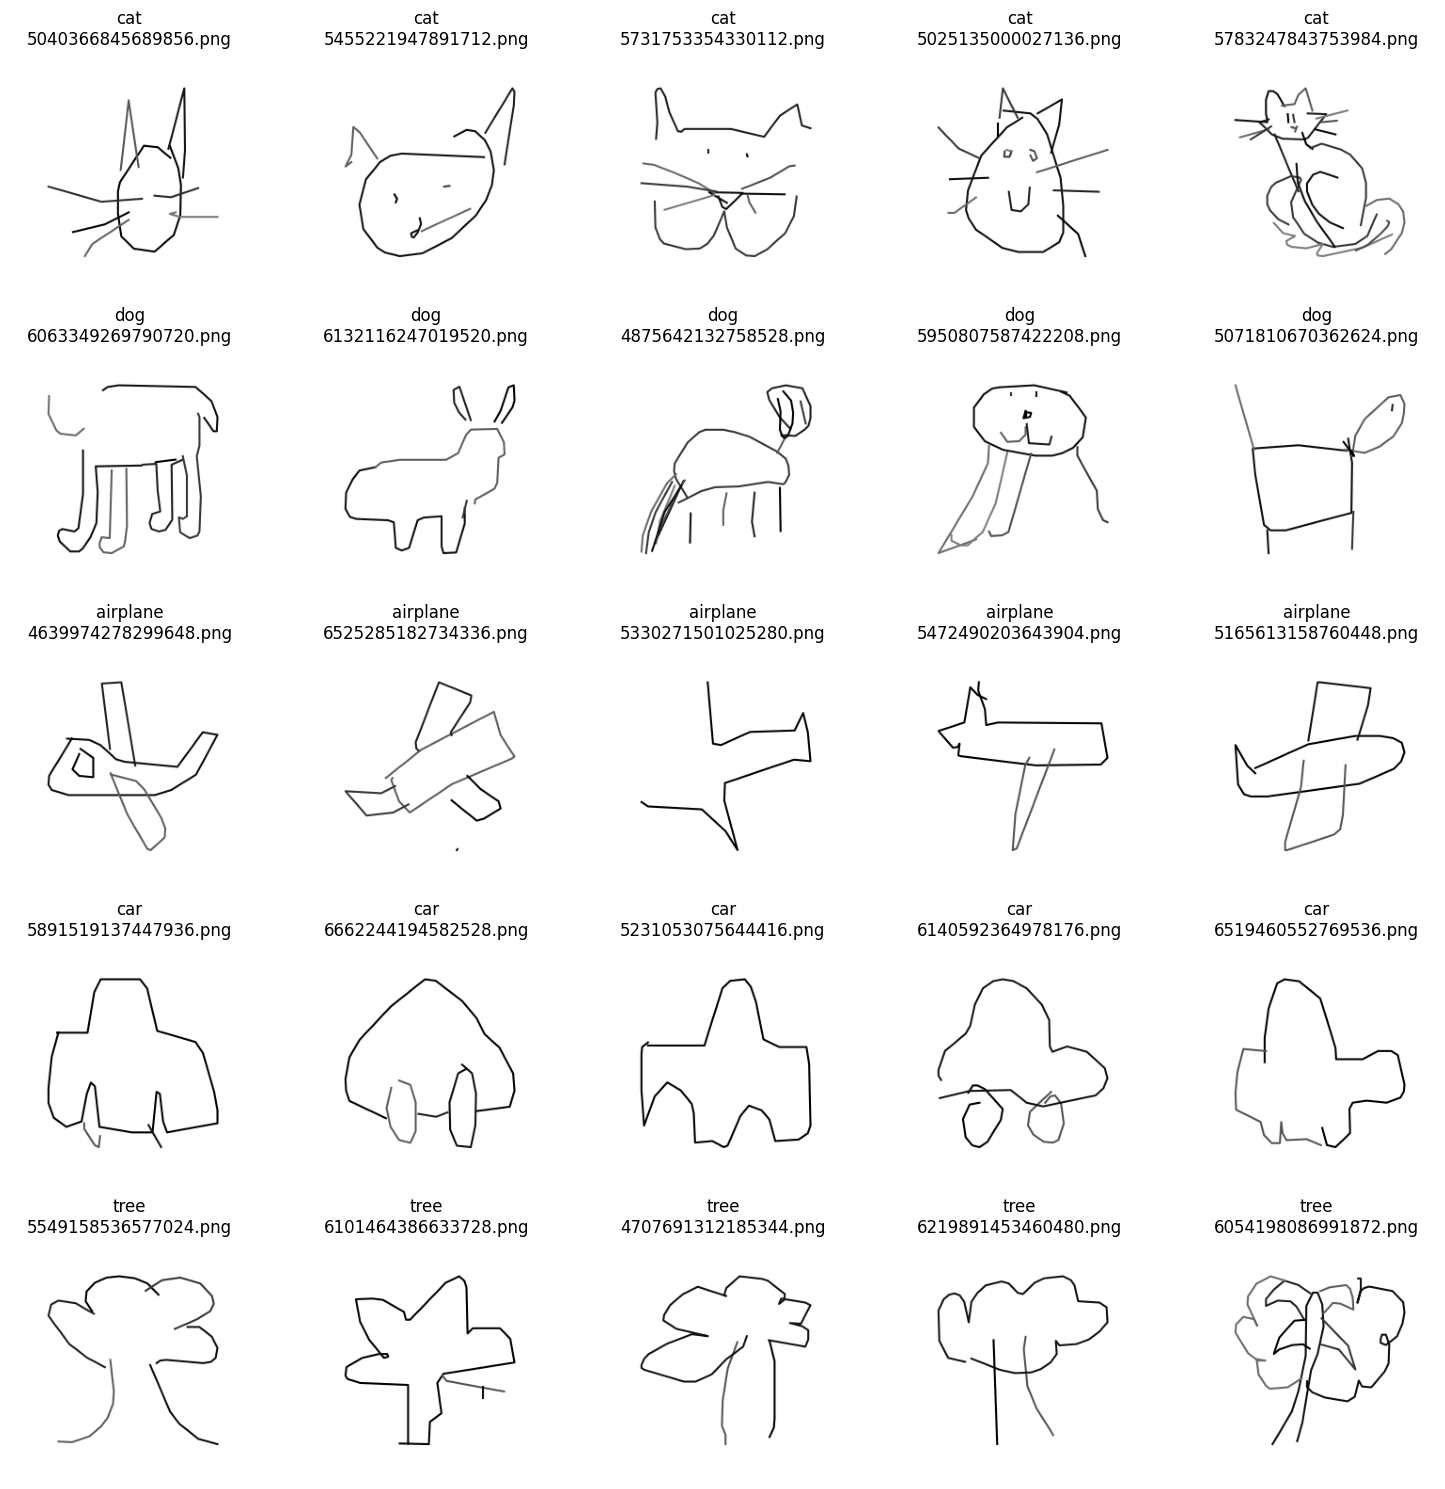

In [ ]:
# Visualize sample images
def display_sample_images(categories_list, num_samples=5):
    """Display sample images from different categories"""
    fig, axes = plt.subplots(len(categories_list), num_samples, figsize=(15, 3*len(categories_list)))
    if len(categories_list) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, category in enumerate(categories_list[:5]):  # Limit to 5 categories for display
        category_path = doodle_dir / category
        if category_path.exists():
            png_files = list(category_path.glob('*.png'))[:num_samples]
            for j, img_path in enumerate(png_files):
                if j < num_samples:
                    img = Image.open(img_path)
                    axes[idx, j].imshow(img, cmap='gray')
                    axes[idx, j].set_title(f"{category}\n{img_path.name}")
                    axes[idx, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display samples from a few categories
sample_categories = ['cat', 'dog', 'airplane', 'car', 'tree']
display_sample_images(sample_categories, num_samples=5)


## 2. Data Preparation


In [ ]:
# Configuration
IMG_SIZE = 64  # Resize images to 64x64
BATCH_SIZE = 32
NUM_CLASSES = None  # Will be determined from data
SELECTED_CATEGORIES = None  # None means use all categories, or specify a list like ['cat', 'dog', 'airplane']
MAX_NUM_CLASSES = 50  # None means use all classes, or specify a number to limit classes (e.g., 10)

# Function to load images and labels from directory structure
def load_images_from_directory(base_dir, categories=None, max_per_category=None, img_size=IMG_SIZE):
    """
    Load images from directory structure
    
    Args:
        base_dir: Base directory containing category folders
        categories: List of categories to load (None = all)
        max_per_category: Maximum images per category (None = all)
        img_size: Target image size
    
    Returns:
        images: numpy array of images
        labels: numpy array of labels
        label_to_idx: dictionary mapping label names to indices
    """
    base_path = Path(base_dir)
    images = []
    labels = []
    
    if categories is None:
        categories = [d.name for d in base_path.iterdir() if d.is_dir()]
    
    label_to_idx = {label: idx for idx, label in enumerate(sorted(categories))}
    idx_to_label = {idx: label for label, idx in label_to_idx.items()}
    
    print(f"Loading images from {len(categories)} categories...")
    
    for category in categories:
        category_path = base_path / category
        if not category_path.exists():
            continue
            
        png_files = list(category_path.glob('*.png'))
        if max_per_category:
            png_files = png_files[:max_per_category]
        
        print(f"  Loading {len(png_files)} images from '{category}'...")
        
        for img_path in png_files:
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize((img_size, img_size))
                img_array = np.array(img) / 255.0  # Normalize to [0, 1]
                images.append(img_array)
                labels.append(label_to_idx[category])
            except Exception as e:
                print(f"    Error loading {img_path}: {e}")
                continue
    
    images = np.array(images)
    labels = np.array(labels)
    
    print(f"\nLoaded {len(images)} images with shape {images.shape}")
    print(f"Number of classes: {len(label_to_idx)}")
    
    return images, labels, label_to_idx, idx_to_label

# Get available categories and limit if MAX_NUM_CLASSES is set
base_path = Path('doodles/doodle')
if SELECTED_CATEGORIES is None:
    available_categories = sorted([d.name for d in base_path.iterdir() if d.is_dir()])
    if MAX_NUM_CLASSES is not None and MAX_NUM_CLASSES > 0:
        available_categories = available_categories[:MAX_NUM_CLASSES]
        print(f"Limiting to first {MAX_NUM_CLASSES} classes: {available_categories}")
    categories_to_load = available_categories
else:
    categories_to_load = SELECTED_CATEGORIES
    if MAX_NUM_CLASSES is not None and MAX_NUM_CLASSES > 0:
        categories_to_load = categories_to_load[:MAX_NUM_CLASSES]
        print(f"Limiting to first {MAX_NUM_CLASSES} classes from SELECTED_CATEGORIES: {categories_to_load}")

# Load data (limiting to reasonable size for initial training)
# Adjust max_per_category based on your hardware and time constraints
print("Loading training data...")
X, y, label_to_idx, idx_to_label = load_images_from_directory(
    'doodles/doodle',
    categories=categories_to_load,
    max_per_category=1000,  # Limit to 1000 images per category for faster training
    img_size=IMG_SIZE
)

NUM_CLASSES = len(label_to_idx)
print(f"\nTotal classes: {NUM_CLASSES}")


Limiting to first 50 classes: ['The Eiffel Tower', 'The Great Wall of China', 'The Mona Lisa', 'airplane', 'alarm clock', 'ambulance', 'angel', 'animal migration', 'ant', 'anvil', 'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball', 'baseball bat', 'basket', 'basketball', 'bat', 'bathtub', 'beach', 'bear', 'beard', 'bed', 'bee', 'belt', 'bench', 'bicycle', 'binoculars', 'bird', 'birthday cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap', 'bowtie', 'bracelet', 'brain', 'bread', 'bridge', 'broccoli', 'broom', 'bucket', 'bulldozer', 'bus']
Loading training data...
Loading images from 50 categories...
  Loading 1000 images from 'The Eiffel Tower'...
  Loading 1000 images from 'The Great Wall of China'...
  Loading 1000 images from 'The Mona Lisa'...
  Loading 1000 images from 'airplane'...
  Loading 1000 images from 'alarm clock'...
  Loading 1000 images from 'ambulance'...
  Loading 1000 images from 'angel'...
  Loading 1000 images from

In [ ]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Image shape: {X_train.shape[1:]}")
print(f"Number of classes: {NUM_CLASSES}")

# Convert labels to categorical
y_train_cat = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_val_cat = keras.utils.to_categorical(y_val, NUM_CLASSES)
y_test_cat = keras.utils.to_categorical(y_test, NUM_CLASSES)


Training set: 35000 samples
Validation set: 7500 samples
Test set: 7500 samples
Image shape: (64, 64, 3)
Number of classes: 50


## 3. Model Architecture


In [ ]:
def create_cnn_model(input_shape, num_classes):
    """
    Create a CNN model for doodle classification
    
    Architecture:
    - Convolutional layers with increasing filters
    - Batch normalization and dropout for regularization
    - Global average pooling before dense layers
    """
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fourth convolutional block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        
        # Dense layers
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create model
input_shape = (IMG_SIZE, IMG_SIZE, 3)
model = create_cnn_model(input_shape, NUM_CLASSES)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

# Display model architecture
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 26, 26, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 11, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 9, 9, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             

 Total params: 743,378 (2.84 MB)

 Trainable params: 741,394 (2.83 MB)

 Non-trainable params: 1,984 (7.75 KB)

## 4. Data Augmentation


In [ ]:
# Create data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    horizontal_flip=False  # Doodles usually shouldn't be flipped
)

# Create data generators
train_generator = datagen.flow(
    X_train, y_train_cat,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Validation data doesn't need augmentation
val_generator = ImageDataGenerator().flow(
    X_val, y_val_cat,
    batch_size=BATCH_SIZE,
    shuffle=False
)


## 5. Training


In [ ]:
# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_doodle_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Calculate steps per epoch
steps_per_epoch = len(X_train) // BATCH_SIZE
validation_steps = len(X_val) // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Train model
EPOCHS = 50

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)


Steps per epoch: 1093
Validation steps: 234
Epoch 1/50
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.1151 - loss: 3.9914 - top_3_accuracy: 0.2507
Epoch 1: val_accuracy improved from None to 0.08694, saving model to best_doodle_model.h5


1093/1093 ━━━━━━━━━━━━━━━━━━━━ 94s 85ms/step - accuracy: 0.1866 - loss: 3.3771 - top_3_accuracy: 0.3713 - val_accuracy: 0.0869 - val_loss: 6.5418 - val_top_3_accuracy: 0.1604 - learning_rate: 0.0010
Epoch 2/50
   1/1093 ━━━━━━━━━━━━━━━━━━━━ 1:28 81ms/step - accuracy: 0.2812 - loss: 2.4058 - top_3_accuracy: 0.5312
Epoch 2: val_accuracy did not improve from 0.08694
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2812 - loss: 2.4058 - top_3_accuracy: 0.5312 - val_accuracy: 0.0816 - val_loss: 7.0210 - val_top_3_accuracy: 0.1490 - learning_rate: 0.0010
Epoch 3/50
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3600 - loss: 2.3667 - top_3_accuracy: 0.6034
Epoch 3: val_accuracy improved from 0.08694 to 0.08948, saving model to best_doodle_model.h5


1093/1093 ━━━━━━━━━━━━━━━━━━━━ 92s 84ms/step - accuracy: 0.3983 - loss: 2.2028 - top_3_accuracy: 0.6456 - val_accuracy: 0.0895 - val_loss: 5.1791 - val_top_3_accuracy: 0.2078 - learning_rate: 0.0010
Epoch 4/50
   1/1093 ━━━━━━━━━━━━━━━━━━━━ 1:28 81ms/step - accuracy: 0.4062 - loss: 2.1006 - top_3_accuracy: 0.7188
Epoch 4: val_accuracy did not improve from 0.08948
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4062 - loss: 2.1006 - top_3_accuracy: 0.7188 - val_accuracy: 0.0807 - val_loss: 5.4674 - val_top_3_accuracy: 0.1876 - learning_rate: 0.0010
Epoch 5/50
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4761 - loss: 1.8741 - top_3_accuracy: 0.7200
Epoch 5: val_accuracy improved from 0.08948 to 0.20633, saving model to best_doodle_model.h5


1093/1093 ━━━━━━━━━━━━━━━━━━━━ 91s 84ms/step - accuracy: 0.4893 - loss: 1.8189 - top_3_accuracy: 0.7346 - val_accuracy: 0.2063 - val_loss: 3.8233 - val_top_3_accuracy: 0.3575 - learning_rate: 0.0010
Epoch 6/50
   1/1093 ━━━━━━━━━━━━━━━━━━━━ 1:34 86ms/step - accuracy: 0.5000 - loss: 1.7709 - top_3_accuracy: 0.7188
Epoch 6: val_accuracy improved from 0.20633 to 0.25868, saving model to best_doodle_model.h5


1093/1093 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5000 - loss: 1.7709 - top_3_accuracy: 0.7188 - val_accuracy: 0.2587 - val_loss: 3.2795 - val_top_3_accuracy: 0.4288 - learning_rate: 0.0010
Epoch 7/50
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5371 - loss: 1.6528 - top_3_accuracy: 0.7713
Epoch 7: val_accuracy did not improve from 0.25868
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 92s 84ms/step - accuracy: 0.5466 - loss: 1.6156 - top_3_accuracy: 0.7781 - val_accuracy: 0.0843 - val_loss: 5.7863 - val_top_3_accuracy: 0.1724 - learning_rate: 0.0010
Epoch 8/50
   1/1093 ━━━━━━━━━━━━━━━━━━━━ 1:22 75ms/step - accuracy: 0.5938 - loss: 1.1644 - top_3_accuracy: 0.8438
Epoch 8: val_accuracy did not improve from 0.25868
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5938 - loss: 1.1644 - top_3_accuracy: 0.8438 - val_accuracy: 0.1038 - val_loss: 5.3788 - val_top_3_accuracy: 0.2063 - learning_rate: 0.0010
Epoch 9/50
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5706 -

1093/1093 ━━━━━━━━━━━━━━━━━━━━ 93s 85ms/step - accuracy: 0.6052 - loss: 1.3806 - top_3_accuracy: 0.8220 - val_accuracy: 0.3503 - val_loss: 2.9758 - val_top_3_accuracy: 0.5517 - learning_rate: 0.0010
Epoch 12/50
   1/1093 ━━━━━━━━━━━━━━━━━━━━ 1:44 96ms/step - accuracy: 0.7188 - loss: 1.0076 - top_3_accuracy: 0.9062
Epoch 12: val_accuracy did not improve from 0.35029
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7188 - loss: 1.0076 - top_3_accuracy: 0.9062 - val_accuracy: 0.3369 - val_loss: 3.0861 - val_top_3_accuracy: 0.5298 - learning_rate: 0.0010
Epoch 13/50
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6321 - loss: 1.2942 - top_3_accuracy: 0.8408
Epoch 13: val_accuracy improved from 0.35029 to 0.50174, saving model to best_doodle_model.h5


1093/1093 ━━━━━━━━━━━━━━━━━━━━ 92s 84ms/step - accuracy: 0.6283 - loss: 1.3041 - top_3_accuracy: 0.8379 - val_accuracy: 0.5017 - val_loss: 1.9531 - val_top_3_accuracy: 0.7189 - learning_rate: 0.0010
Epoch 14/50
   1/1093 ━━━━━━━━━━━━━━━━━━━━ 1:41 93ms/step - accuracy: 0.6875 - loss: 0.9168 - top_3_accuracy: 0.9062
Epoch 14: val_accuracy improved from 0.50174 to 0.60938, saving model to best_doodle_model.h5


1093/1093 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6875 - loss: 0.9168 - top_3_accuracy: 0.9062 - val_accuracy: 0.6094 - val_loss: 1.3945 - val_top_3_accuracy: 0.8140 - learning_rate: 0.0010
Epoch 15/50
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6429 - loss: 1.2472 - top_3_accuracy: 0.8480
Epoch 15: val_accuracy did not improve from 0.60938
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 93s 85ms/step - accuracy: 0.6437 - loss: 1.2451 - top_3_accuracy: 0.8484 - val_accuracy: 0.1331 - val_loss: 5.6272 - val_top_3_accuracy: 0.2394 - learning_rate: 0.0010
Epoch 16/50
   1/1093 ━━━━━━━━━━━━━━━━━━━━ 1:29 82ms/step - accuracy: 0.4688 - loss: 1.6778 - top_3_accuracy: 0.7188
Epoch 16: val_accuracy did not improve from 0.60938
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4688 - loss: 1.6778 - top_3_accuracy: 0.7188 - val_accuracy: 0.1346 - val_loss: 5.6200 - val_top_3_accuracy: 0.2408 - learning_rate: 0.0010
Epoch 17/50
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6

1093/1093 ━━━━━━━━━━━━━━━━━━━━ 93s 85ms/step - accuracy: 0.7009 - loss: 1.0383 - top_3_accuracy: 0.8837 - val_accuracy: 0.7792 - val_loss: 0.7680 - val_top_3_accuracy: 0.9219 - learning_rate: 5.0000e-04
Epoch 22/50
   1/1093 ━━━━━━━━━━━━━━━━━━━━ 1:42 94ms/step - accuracy: 0.6562 - loss: 0.8880 - top_3_accuracy: 0.9062
Epoch 22: val_accuracy did not improve from 0.77925
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6562 - loss: 0.8880 - top_3_accuracy: 0.9062 - val_accuracy: 0.7763 - val_loss: 0.7744 - val_top_3_accuracy: 0.9213 - learning_rate: 5.0000e-04
Epoch 23/50
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7065 - loss: 0.9987 - top_3_accuracy: 0.8922
Epoch 23: val_accuracy did not improve from 0.77925
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 93s 85ms/step - accuracy: 0.7118 - loss: 0.9920 - top_3_accuracy: 0.8919 - val_accuracy: 0.2054 - val_loss: 4.5315 - val_top_3_accuracy: 0.3535 - learning_rate: 5.0000e-04
Epoch 24/50
   1/1093 ━━━━━━━━━━━━━━━━━━━━ 1:41 93ms/step

## 6. Training History Visualization


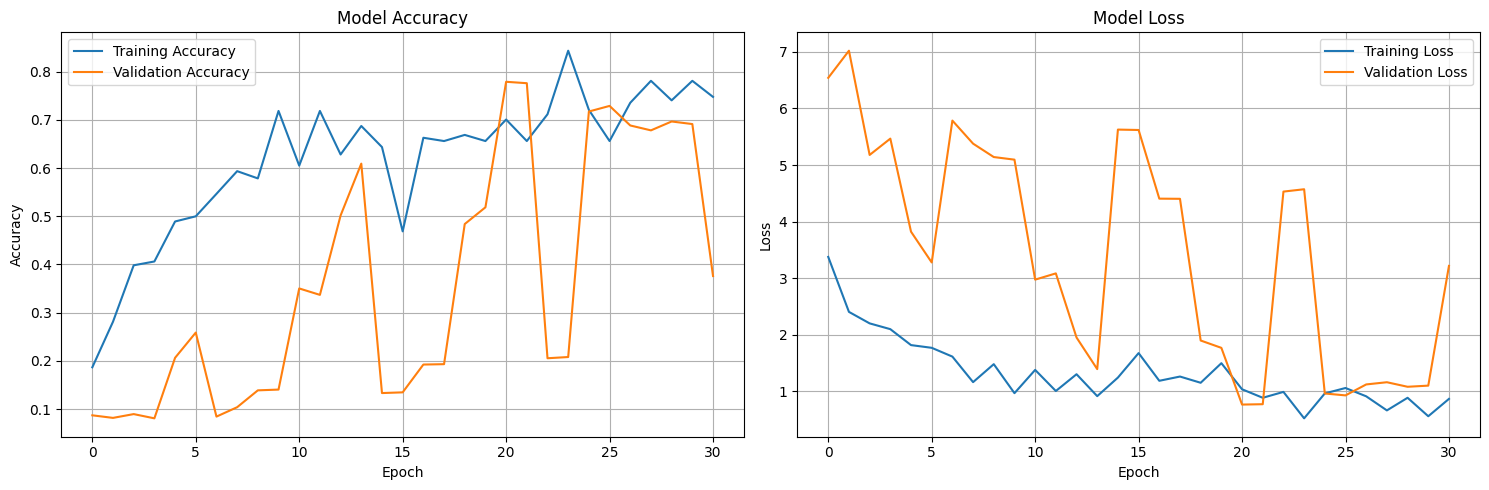

In [ ]:
# Plot training history
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss plot
    axes[1].plot(history.history['loss'], label='Training Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)


## 7. Model Evaluation


In [ ]:
# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_accuracy, test_top3_accuracy = model.evaluate(X_test, y_test_cat, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Top-3 Accuracy: {test_top3_accuracy:.4f}")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=[idx_to_label[i] for i in range(NUM_CLASSES)]
))


Evaluating on test set...
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7839 - loss: 0.7501 - top_3_accuracy: 0.9244

Test Loss: 0.7501
Test Accuracy: 0.7839
Test Top-3 Accuracy: 0.9244
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step

Classification Report:
                         precision    recall  f1-score   support

       The Eiffel Tower       0.99      0.89      0.93       150
The Great Wall of China       0.76      0.35      0.48       150
          The Mona Lisa       0.94      0.98      0.96       150
               airplane       0.88      0.85      0.86       150
            alarm clock       0.68      0.85      0.75       150
              ambulance       0.81      0.91      0.86       150
                  angel       0.77      0.92      0.84       150
       animal migration       0.61      0.91      0.73       150
                    ant       0.86      0.89      0.88       150
                  anvil       0.84      0.87      0.86       150
                  appl

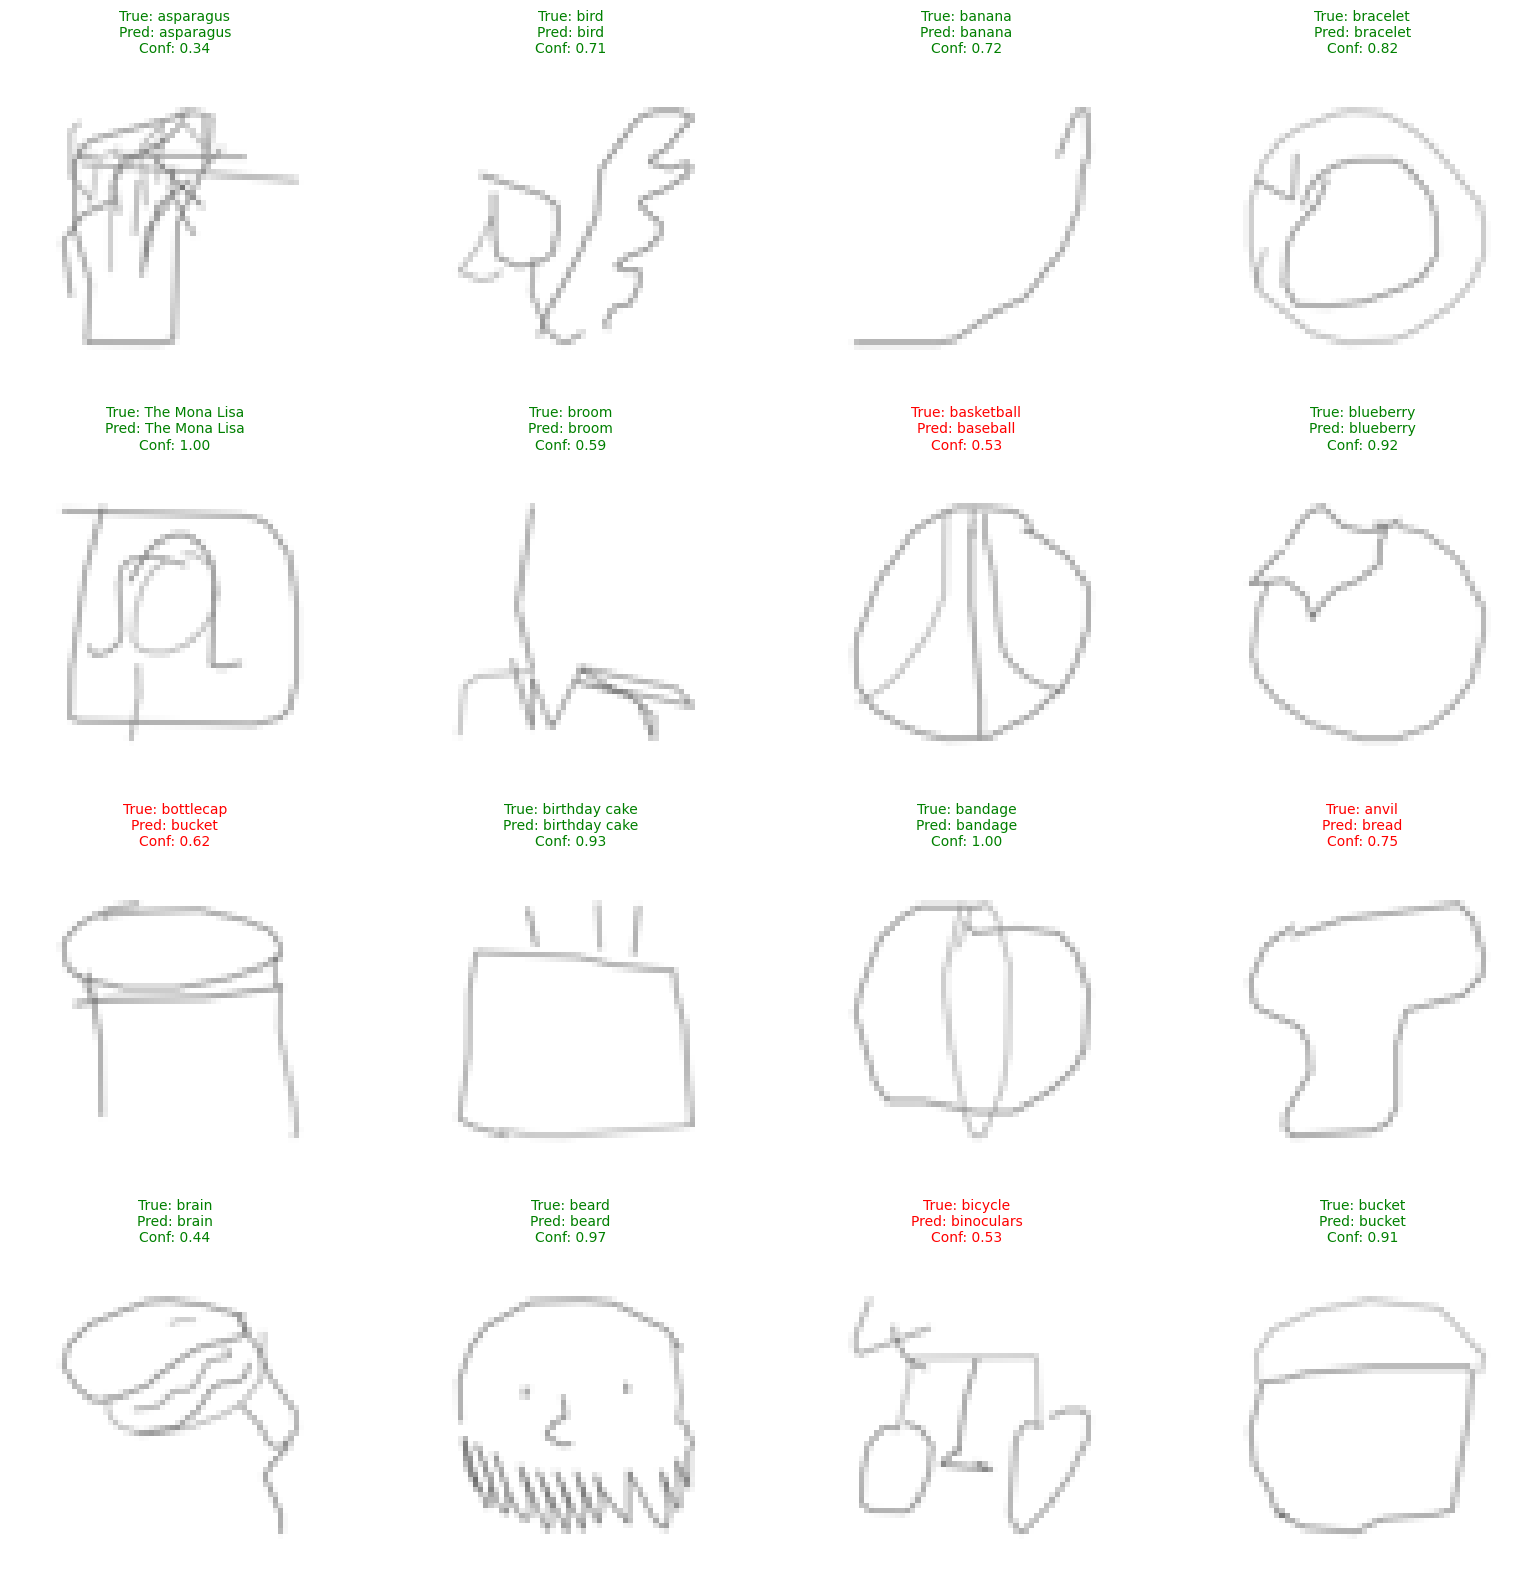

In [ ]:
# Visualize predictions on sample test images
def visualize_predictions(X_test, y_true, y_pred_classes, y_pred_probs, idx_to_label, num_samples=16):
    """Visualize model predictions on test images"""
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.ravel()
    
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        img = X_test[idx]
        true_label = idx_to_label[y_true[idx]]
        pred_label = idx_to_label[y_pred_classes[idx]]
        confidence = y_pred_probs[idx][y_pred_classes[idx]]
        
        axes[i].imshow(img)
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}', 
                         color=color, fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(X_test, y_true_classes, y_pred_classes, y_pred, idx_to_label, num_samples=16)


## 8. Save Model and Labels


In [62]:
# Save the final model
model.save('doodle_recognition_model.h5')
print("Model saved as 'doodle_recognition_model.h5'")

# Save label mappings
import json
with open('label_mappings.json', 'w') as f:
    json.dump({
        'label_to_idx': label_to_idx,
        'idx_to_label': idx_to_label
    }, f, indent=2)
print("Label mappings saved as 'label_mappings.json'")

# Save model info
model_info = {
    'img_size': IMG_SIZE,
    'num_classes': NUM_CLASSES,
    'batch_size': BATCH_SIZE,
    'test_accuracy': float(test_accuracy),
    'test_top3_accuracy': float(test_top3_accuracy)
}

with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)
print("Model info saved as 'model_info.json'")


Model saved as 'doodle_recognition_model.h5'
Label mappings saved as 'label_mappings.json'
Model info saved as 'model_info.json'


## 9. Inference Function

Use this function to predict doodles from new images.


In [63]:
def predict_doodle(image_path, model, idx_to_label, img_size=IMG_SIZE, top_k=5):
    """
    Predict doodle category from an image file
    
    Args:
        image_path: Path to image file
        model: Trained Keras model
        idx_to_label: Dictionary mapping indices to labels
        img_size: Target image size
        top_k: Number of top predictions to return
    
    Returns:
        List of (label, confidence) tuples
    """
    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    img = img.resize((img_size, img_size))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict
    predictions = model.predict(img_array, verbose=0)[0]
    
    # Get top k predictions
    top_indices = np.argsort(predictions)[-top_k:][::-1]
    top_predictions = [(idx_to_label[idx], float(predictions[idx])) for idx in top_indices]
    
    return top_predictions

# Example usage
print("Example prediction:")
sample_image = list(Path('doodles/doodle/cat').glob('*.png'))[0]
predictions = predict_doodle(sample_image, model, idx_to_label, top_k=5)
print(f"\nImage: {sample_image}")
for label, confidence in predictions:
    print(f"  {label}: {confidence:.4f}")


Example prediction:

Image: doodles/doodle/cat/5040366845689856.png
  bulldozer: 0.1519
  binoculars: 0.1254
  airplane: 0.1104
  beach: 0.1103
  belt: 0.1061
